In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from scipy import spatial
import os
import merge_bubbles_3d_v2 as merge
from matplotlib.colors import hsv_to_rgb
import advect_bubbles_3D_eval as adv
import pickle

N_realisation = 38
np.random.seed(N_realisation)  

Generate uniformly distributed particles in the domain, then put particles into grid cells. Two stagger sets of grids, `gridA` and `gridB`. Params to set:
- number of particles
- St0, Fr
- critical collision distance

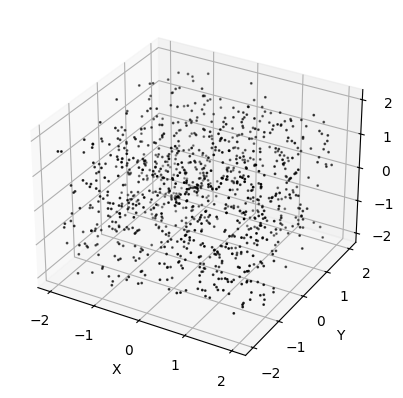

In [2]:
N0_particle = 10 ** 3

XP0 = np.random.uniform(-2, 2, N0_particle) 
YP0 = np.random.uniform(-2, 2, N0_particle)
ZP0 = np.random.uniform(-2, 2, N0_particle)

St0 = 0.25
R_collision = 0.02
Fr = 0.5

xl, xr = -2, 2
yl, yr = -2, 2
zd, zu = -2, 2

dx_col, dy_col, dz_col = 1, 1, 1
Nx_col, Ny_col, Nz_col = 4, 4, 4
gridA_xc, gridA_yc, gridA_zc = np.meshgrid(np.linspace(xl+dx_col/2, xr-dx_col/2, Nx_col), 
                                           np.linspace(yl+dy_col/2, yr-dy_col, Ny_col), 
                                           np.linspace(zd+dz_col/2, zu-dz_col/2, Nz_col), indexing='ij')
gridB_xc, gridB_yc, gridB_zc = np.meshgrid(np.linspace(xl, xr, Nx_col+1), np.linspace(yl, yr, Ny_col+1), np.linspace(zd, zu, Nz_col+1), indexing='ij')

# Plot grid lines
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# # Plot lines along x-axis
# for i in range(Ny_col):
#     for j in range(Nz_col):
#         ax.plot(gridA_xc[:, i, j], gridA_yc[:, i, j], gridA_zc[:, i, j], color='r',linestyle='--')

# # Plot lines along y-axis
# for i in range(Nx_col):
#     for j in range(Nz_col):
#         ax.plot(gridA_xc[i, :, j], gridA_yc[i, :, j], gridA_zc[i, :, j], color='g',linestyle='--')


# # Plot lines along z-axis
# for i in range(Nx_col):
#     for j in range(Ny_col):
#         ax.plot(gridA_xc[i, j, :], gridA_yc[i, j, :], gridA_zc[i, j, :], color='b',linestyle='--')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(XP0, YP0, ZP0,s=1, c='k', marker='o')


plt.show()

Initialise the Lagrangian table

In [3]:
Bubbles_df_ini = np.zeros((N0_particle, 15), dtype=np.float64)

# first column is bubbles ID
Bubbles_df_ini[:, 0] = np.arange(N0_particle)

# second column is bubbles X position
Bubbles_df_ini[:, 1] = XP0.flatten().astype(float)

# third column is bubbles Y position   
Bubbles_df_ini[:, 2] = YP0.flatten().astype(float)

# fourth column is bubbles Z position
Bubbles_df_ini[:, 3] = ZP0.flatten().astype(float)

# fourth column is bubbles x-velocity
Bubbles_df_ini[:, 4] = np.zeros(N0_particle)

# fifth column is bubbles y-velocity
Bubbles_df_ini[:, 5] = np.zeros(N0_particle)

# sixth column is bubbles z-velocity
Bubbles_df_ini[:, 6] = np.zeros(N0_particle)

# sixth column is bubbles Stokes number
Bubbles_df_ini[:, 7] = St0

# seventh column is bubbles slaved status
Bubbles_df_ini[:, 8] = False

# eighth column is bubbles gridA x-index
Bubbles_df_ini[:, 9] = np.floor((Bubbles_df_ini[:, 1] - xl ) / dx_col).astype(int)

# ninth column is bubbles gridA y-index
Bubbles_df_ini[:, 10] = np.floor((Bubbles_df_ini[:, 2] - yl ) / dy_col).astype(int)

# tenth column is bubbles gridA z-index
Bubbles_df_ini[:, 11] = np.floor((Bubbles_df_ini[:, 3] - zd ) / dz_col).astype(int)

# tenth column is bubbles gridB x-index
Bubbles_df_ini[:, 12] = np.floor((Bubbles_df_ini[:, 1]- xl + dx_col / 2) / dx_col).astype(int)

# eleventh column is bubbles gridB y-index	
Bubbles_df_ini[:, 13] = np.floor((Bubbles_df_ini[:, 2]- yl + dy_col / 2) / dy_col).astype(int)

# twelfth column is bubbles gridB z-index
Bubbles_df_ini[:, 14] = np.floor((Bubbles_df_ini[:, 3]- zd + dz_col / 2) / dz_col).astype(int)

# ditch the ones about to leave the domain 
Bubbles_df_ini = Bubbles_df_ini[(Bubbles_df_ini[:, 1] >= xl) & (Bubbles_df_ini[:, 1] < xr) 
                                & (Bubbles_df_ini[:, 2] >= yl) & (Bubbles_df_ini[:, 2] < yr)
                                & (Bubbles_df_ini[:, 3] >= zd) & (Bubbles_df_ini[:, 3] < zu)]

Bubbles coming from upstream reservoir 

Text(0.5, 0, 'Z')

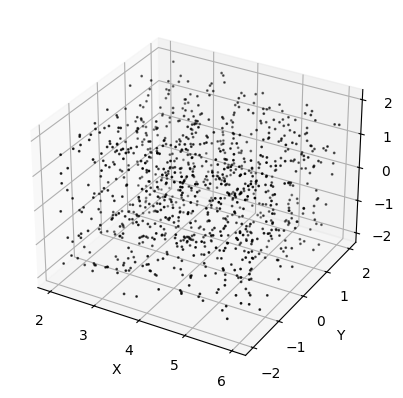

In [4]:
x_far = 6
x_res = np.linspace(xr, x_far, 100)
y_res, z_res = np.linspace(yl, yr, 100), np.linspace(zd, zu, 100)
X_res, Y_res, Z_res = np.meshgrid(x_res, y_res, z_res, indexing='ij')

N0_particle_res = N0_particle

XP0_res = np.random.uniform(xr, x_far, N0_particle_res)
YP0_res = np.random.uniform(yl, yr, N0_particle_res)
ZP0_res = np.random.uniform(zd, zu, N0_particle_res)
St0_res = St0

# plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XP0_res, YP0_res, ZP0_res,s=1, c='k', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Pool - Bubble coming from below


Text(0.5, 0, 'Z')

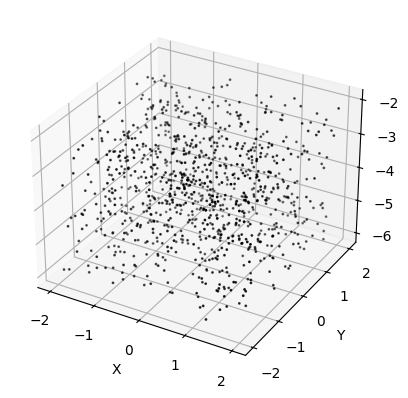

In [5]:
z_far = -6

x_pool, y_pool = np.linspace(xl, xr, 100), np.linspace(yl, yr, 100)
z_pool = np.linspace(z_far, zd, 100)
X_pool, Y_pool, Z_pool = np.meshgrid(x_pool, y_pool, z_pool, indexing='ij')

N0_particle_pool = N0_particle

XP0_pool = np.random.uniform(xl, xr, N0_particle_pool)
YP0_pool = np.random.uniform(yl, yr, N0_particle_pool)
ZP0_pool = np.random.uniform(z_far, zd, N0_particle_pool)
St0_pool = St0

# plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XP0_pool, YP0_pool, ZP0_pool,s=1, c='k', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Build a df from reservoir bubbles to track their Lagrangian trajectories\
All reservoir bubbles are released from rest and get advected by background flows

In [6]:
Res_df_ini_0 = np.zeros((N0_particle_res, 8), dtype=np.float64)
Pool_df_ini_0 = np.zeros((N0_particle_pool, 8), dtype=np.float64)

# first column is bubbles ID
Res_df_ini_0[:, 0] = np.arange(N0_particle_res) + N0_particle
Pool_df_ini_0[:, 0] = np.arange(N0_particle_pool) + N0_particle + N0_particle_res

# second column is bubbles X position
Res_df_ini_0[:, 1] = XP0_res.flatten().astype(float)
Pool_df_ini_0[:, 1] = XP0_pool.flatten().astype(float)

# third column is bubbles Y position
Res_df_ini_0[:, 2] = YP0_res.flatten().astype(float)
Pool_df_ini_0[:, 2] = YP0_pool.flatten().astype(float)

# fourth column is bubbles Z position
Res_df_ini_0[:, 3] = ZP0_res.flatten().astype(float)
Pool_df_ini_0[:, 3] = ZP0_pool.flatten().astype(float)

# fifth, sixth, seventh columns are bubbles x/y/z-velocity
Res_df_ini_0[:, 4:7] = np.zeros((N0_particle_res, 3))
Pool_df_ini_0[:, 4:7] = np.zeros((N0_particle_pool, 3))

# eighth column is bubbles Stokes number
Res_df_ini_0[:, 7] = St0_res
Pool_df_ini_0[:, 7] = St0_pool

In [7]:
def supplement_reservoir(res_df_to_fill, N0_res_full, n_already_supplemented, from_where):

    # supply the reservoir with new bubbles to main the total number
    N_supplement = N0_res_full - res_df_to_fill.shape[0]

    # generate new bubbles
    new_bubbles_df = np.zeros((N_supplement, 8), dtype=np.float64)

    if from_where == 'upstream':

        # first column is bubbles ID
        new_bubbles_df[:, 0] = np.arange(N_supplement) + n_already_supplemented + 100000

        # second column is bubbles X position
        new_bubbles_df[:, 1] = np.random.uniform((x_far+xr)/2, x_far, N_supplement)

        # third column is bubbles Y position    
        new_bubbles_df[:, 2] = np.random.uniform(yl, yr, N_supplement)
        
        # fourth column is bubbles Z position
        new_bubbles_df[:, 3] = np.random.uniform(zd, zu, N_supplement)
    
    elif from_where == 'below':
            
            # first column is bubbles ID
            new_bubbles_df[:, 0] = np.arange(N_supplement) + n_already_supplemented + 1000000
    
            # second column is bubbles X position
            new_bubbles_df[:, 1] = np.random.uniform(xl, xr, N_supplement)
    
            # third column is bubbles Y position    
            new_bubbles_df[:, 2] = np.random.uniform(yl, yr, N_supplement)
            
            # fourth column is bubbles Z position
            new_bubbles_df[:, 3] = np.random.uniform(z_far, zd, N_supplement)
    
    else:
        raise ValueError('from_where should be either "upstream" or "below"')

    # fifth, sixth, seventh columns are bubbles x/y/z-velocity
    new_bubbles_df[:, 4:7] = np.zeros((N_supplement, 3))

    # eighth column is bubbles Stokes number
    new_bubbles_df[:, 7] = St0_res

    # concatenate the new bubbles to the reservoir
    res_df_to_fill = np.concatenate((res_df_to_fill, new_bubbles_df), axis=0)

    return res_df_to_fill, N_supplement

In [8]:
def create_injected_bubbles_df(injected_bubbles_df):

    if len(injected_bubbles_df) > 0:
        # make a df for the injected bubbles, and then extend it to the Bubbles_df_to_adv before calling merge
        injected_bubbles_df = np.hstack((injected_bubbles_df, np.zeros((injected_bubbles_df.shape[0], 7), dtype=np.float64)))

        # # eighth column is bubbles Stokes number
        # injected_bubbles_df[:, 7] = St0_res

        # ninth column is bubbles slaved status
        injected_bubbles_df[:, 8] = False

        return injected_bubbles_df
    

Ux_avg = 0.12636021708255896 and supplement period is 3.166. W_rising = 1.0 and sup period is 3.000


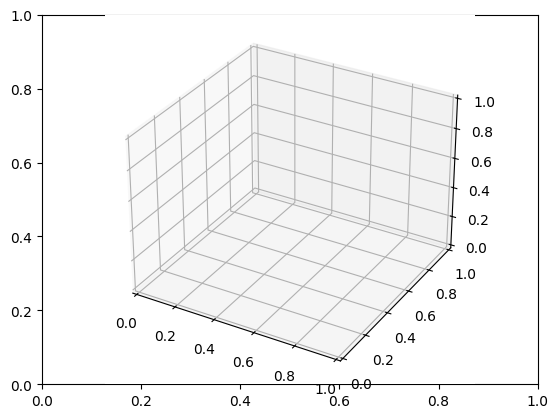

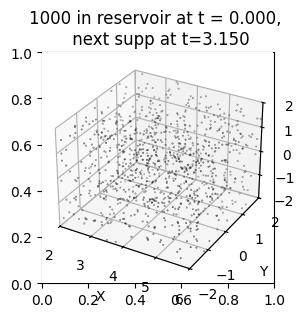

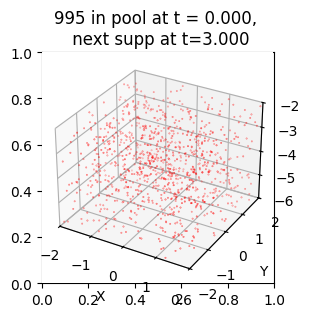

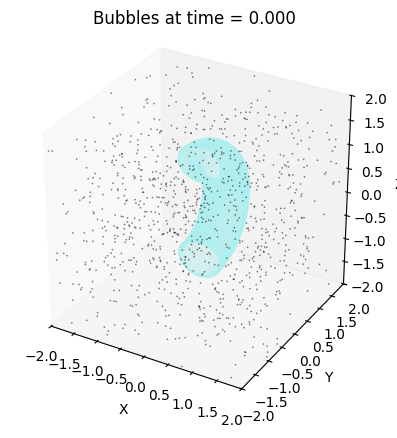

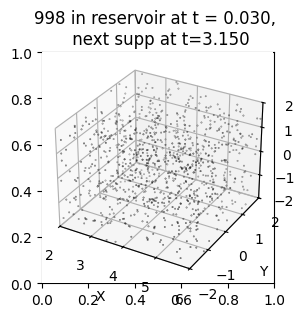

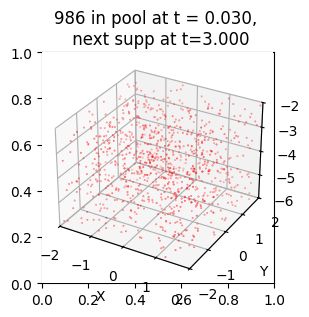

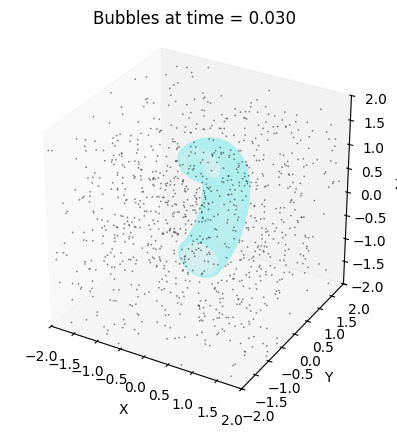

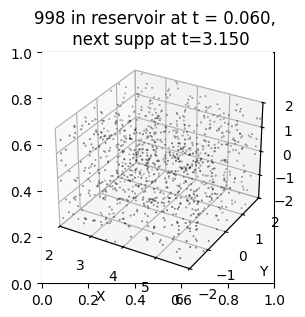

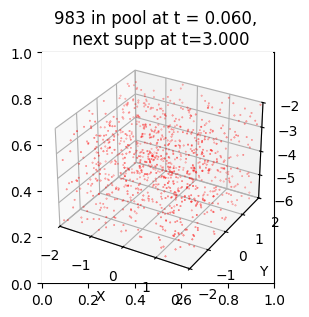

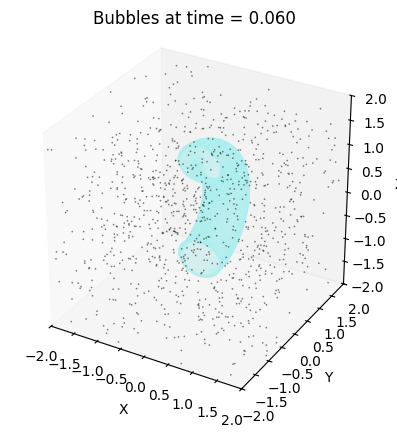

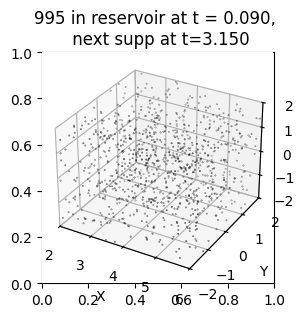

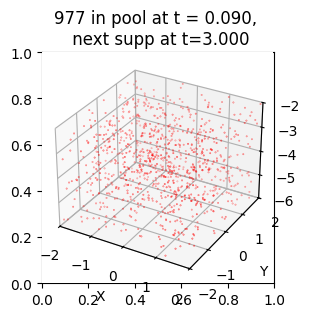

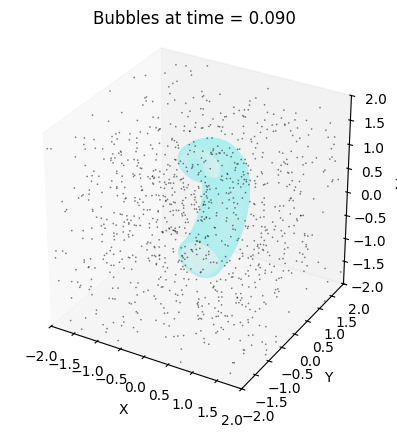

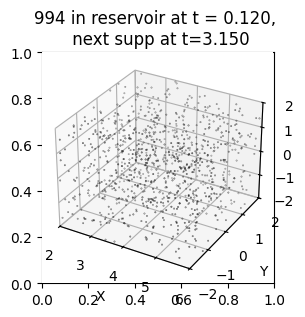

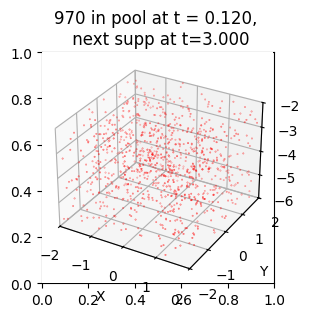

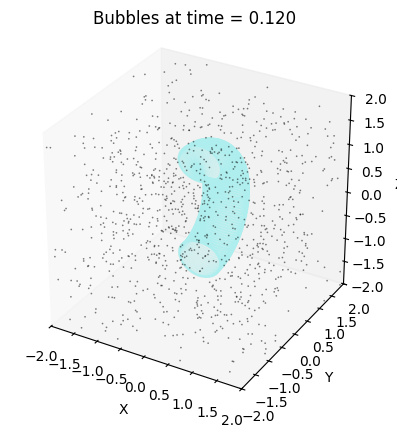

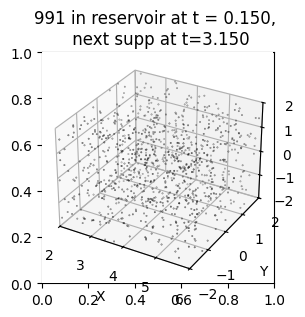

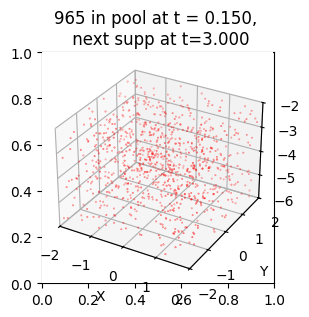

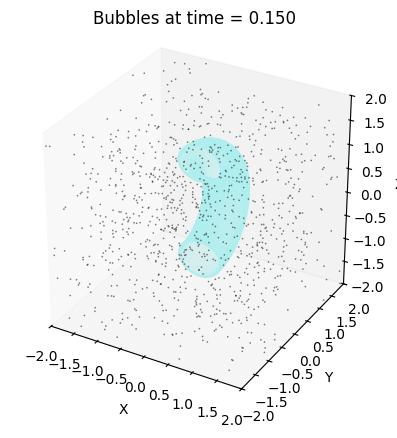

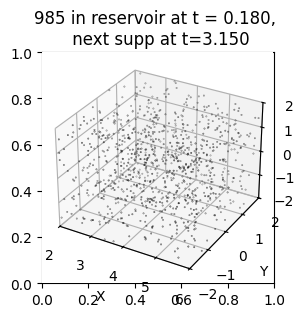

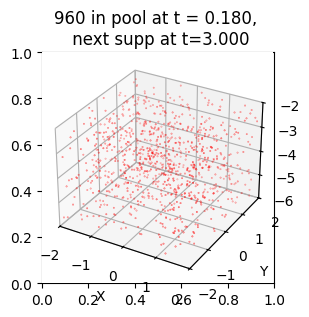

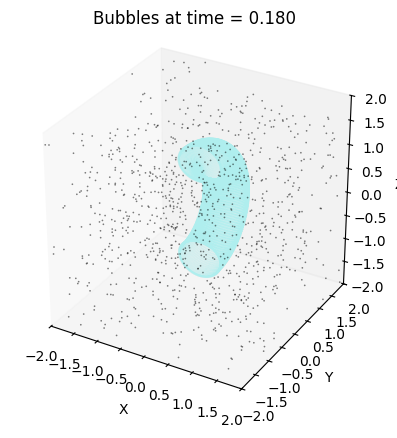

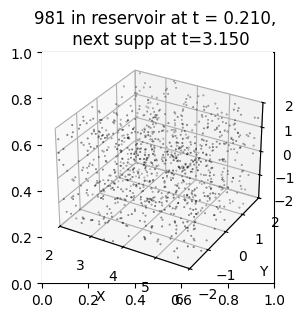

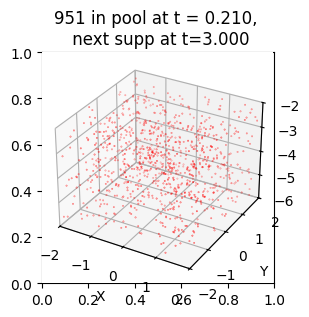

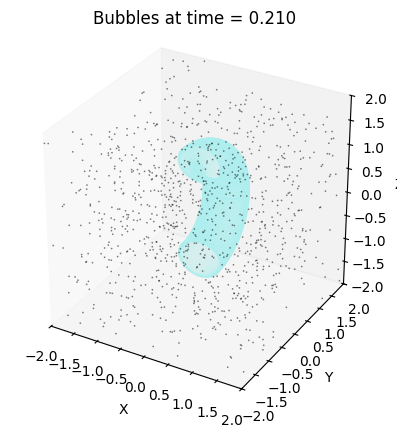

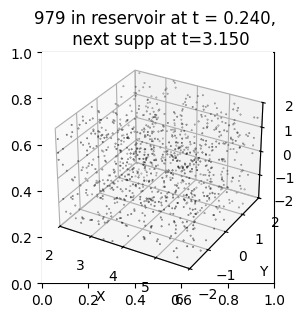

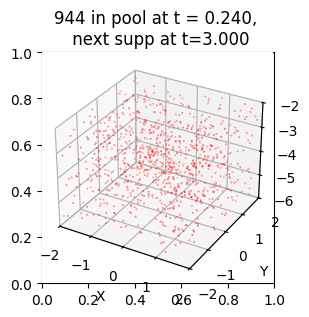

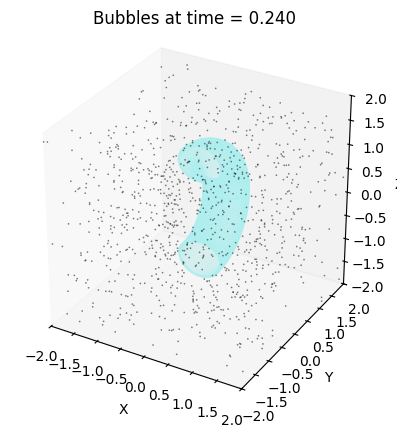

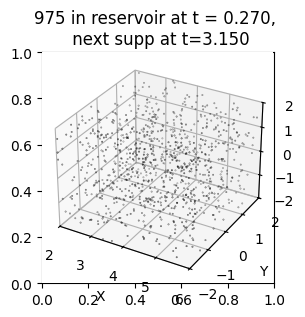

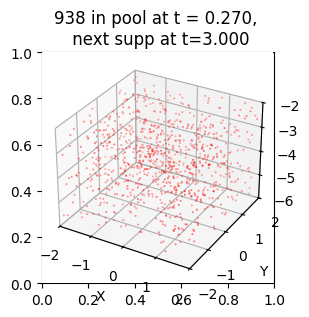

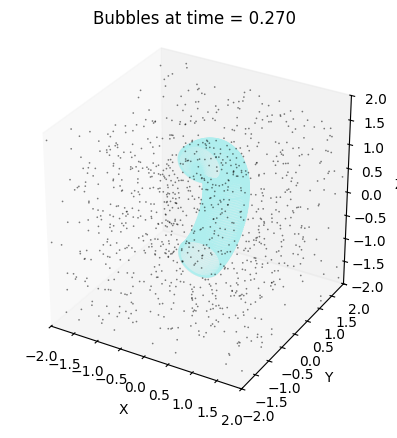

In [9]:
tNow = 0
dt = 0.03
tEnd = 0.3
st_lim = 7
R_bounce = R_collision

N_tot = int((tEnd - tNow) / dt + 1)
N_mergeCycle = np.zeros(2, dtype=int)
N_feedCycle = N_tot * np.ones(2, dtype=int)
Nbub_already_supplemented = np.zeros(2)

W_rising = St0_pool / (Fr**2)  # normalized by U_f
flux_from_pool = N0_particle_pool * W_rising / (zd - z_far)  # normalized by 1/t_f
N_in_from_pool = flux_from_pool * dt  # number of bubbles injected from the pool per time step

Bubbles_df_after_merge = Bubbles_df_ini.copy()
Res_df_ini = Res_df_ini_0.copy()
Pool_df_ini = Pool_df_ini_0.copy()
Pool_df_ini[:, 6] = W_rising

V, H = np.mgrid[0:1:351j, 0:1:351j]
colors_hsv = np.dstack((H, np.ones_like(H), V))
colors_rgb = hsv_to_rgb(colors_hsv)

fig, ax = plt.subplots()
ax = fig.add_subplot(111, projection='3d')

collision_series = []
masters_slaves_series = []
influx_series = []
folder_path = 'influx_random_sims_3D_duo/temp'

while tNow < tEnd:

    # if feeding in bubbles
    if len(Res_df_ini) > 0:
        # advect randomly seeded bubbles in the reservoir, WITHOUT GRAVITY
        updated_states_res = adv.advect_bubbles_res(Res_df_ini, t0=tNow, tf=tNow+dt,plot_path=False, this_ax=ax)
        updated_states_pool = Pool_df_ini[:, 1:7].copy()
        updated_states_pool[:, 2] += W_rising * dt

        # update the ORIGINAL reservoir df
        # create a df for the injected bubbles, and then extend it to the Bubbles_df_to_adv before calling merge
        # then remove the injected bubbles from the reservoir
        Res_df_ini[:, 1:7] = updated_states_res
        injected_bubbles_df_res = Res_df_ini[updated_states_res[:, 0] <= xr]
        Res_df_ini = Res_df_ini[updated_states_res[:, 0] > xr]

        # update the ORIGINAL pool df
        Pool_df_ini[:, 1:7] = updated_states_pool
        injected_bubbles_df_pool = Pool_df_ini[updated_states_pool[:, 2] >= zd]
        Pool_df_ini = Pool_df_ini[Pool_df_ini[:, 3] < zd]

        # record how many bubbles have been injected into the domain
        influx_series.append(len(injected_bubbles_df_res) + len(injected_bubbles_df_pool))


        # for the first cycle, estimate the average axial velocity of bubbles in the reservoir, mean(V_x,res)
        if N_mergeCycle.all() == 0:
            # Ux_avg = np.abs(np.mean(Res_df_ini[:, 4])) 
            Ux_avg = np.abs(np.mean(Res_df_ini[Res_df_ini[:, 1] <= 4, 4])) * 1
            # az = (1.5*2-1)/(Fr**2)       # gravitational acceleration of the bubbles, assume uniformly density ratio R=2
            # Ux_avg = 0.4428

            # calculate the time step for supplementing the UPSTREAM HALF of the reservoir
            # dt_supplement = np.array([0.1*(x_far - xr) / Ux_avg, 0.75*(zd-z_far)/W_rising])  # assume length scale R0=1
            dt_supplement = np.array([0.1*(x_far - xr) / Ux_avg, 0.75*(zd-z_far)/W_rising])  # assume length scale R0=1
          
            # initiate the next supplemnet cycle
            N_feedCycle = N_mergeCycle + np.array(dt_supplement / dt, dtype=int)

            print('Ux_avg = {} and supplement period is {:.3f}. W_rising = {} and sup period is {:.3f}'.format(Ux_avg, dt_supplement[0], W_rising, dt_supplement[1]))

        # if it is time to supplement the reservoir
        if N_mergeCycle[0] == N_feedCycle[0]:
            # feed the EMPTY UPSTREAM HALF of reservoir bubbles 
            Res_df_ini, N_newly_added_res = supplement_reservoir(Res_df_ini, N0_particle_res, Nbub_already_supplemented[0], 'upstream')

            # update calculate the next supplement cycle
            N_feedCycle[0] = N_mergeCycle[0] + int(dt_supplement[0] / dt)

            # update the total number of bubbles already supplemented
            Nbub_already_supplemented[0] += N_newly_added_res

            print('{} bubbles are added to the reservoir, \n next cycle of supplement at {:.2f}'.format(N_newly_added_res, N_feedCycle[0]))
        
        if N_mergeCycle[1] == N_feedCycle[1]:
            # feed the EMPTY BELOW HALF of reservoir bubbles 
            Pool_df_ini, N_newly_added_pool = supplement_reservoir(Pool_df_ini, N0_particle_pool, Nbub_already_supplemented[1], 'below')

            # update calculate the next supplement cycle
            N_feedCycle[1] = N_mergeCycle[1] + int(dt_supplement[1] / dt)

            # update the total number of bubbles already supplemented
            Nbub_already_supplemented[1] += N_newly_added_pool

            print('{} bubbles are added to the pool, \n next cycle of supplement at {:.2f}'.format(N_newly_added_pool, N_feedCycle[1]))
        
        # plot the reservoir bubbles at this iteration
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter3D(Res_df_ini[:, 1], Res_df_ini[:, 2], Res_df_ini[:, 3], s=0.1, c='k', marker='o')
        ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')
        ax.set_xlim(xr, x_far), ax.set_ylim(yl, yr), ax.set_zlim(zd, zu)
        ax.set_title('{} in reservoir at t = {:.3f}, \n next supp at t={:.3f}'.format(Res_df_ini.shape[0], tNow, N_feedCycle[0]*dt))
        plt.show()

        fig2, ax2 = plt.subplots(1, 1, figsize=(3, 3))
        ax2 = fig2.add_subplot(111, projection='3d')
        ax2.scatter3D(Pool_df_ini[:, 1], Pool_df_ini[:, 2], Pool_df_ini[:, 3], s=0.1, c='r', marker='o')
        ax2.set_xlabel('X'), ax2.set_ylabel('Y'), ax2.set_zlabel('Z')
        ax2.set_xlim(xl, xr), ax2.set_ylim(yl, yr), ax2.set_zlim(z_far, zd)
        ax2.set_title('{} in pool at t = {:.3f}, \n next supp at t={:.3f}'.format(Pool_df_ini.shape[0], tNow, N_feedCycle[1]*dt))
        plt.show()

        # feed the reservoir bubbles into the main domain
        # N_injected = np.array([np.sum(updated_states_res[:, 0] <= xr), np.sum(updated_states_pool[:, 2] >= zd)], dtype=int)
        updated_states_injected_res = updated_states_res[updated_states_res[:, 0] <= xr]
        updated_states_injected_pool = updated_states_pool[updated_states_pool[:, 2] >= zd]

        # advect Bubbles_df_to_adv
        Bubbles_df_to_adv = Bubbles_df_after_merge.copy()
        # updated_states = np.asarray(pab3d.main(initial_states=Bubbles_df_to_adv[:, 1:8], t0=tNow, tf=tNow+dt), dtype=np.float64).T
        updated_states = adv.advect_bubbles(Bubbles_df_to_adv, t0=tNow, tf=tNow+dt,plot_path=False, this_ax=None)

        # expand the injecteed bubbles df to the same size as the advected bubbles df
        injected_bubbles_df_res = create_injected_bubbles_df(injected_bubbles_df_res)
        injected_bubbles_df_pool = create_injected_bubbles_df(injected_bubbles_df_pool)


        # if injected_bubbles_df is not None:
        #     # stack the df's of the bubbles in the domain and the injected bubbles together
        #     Bubbles_df_before_merge = np.vstack((Bubbles_df_to_adv, injected_bubbles_df))
        #     total_updated_states = np.vstack((updated_states, updated_states_injected))
        # else:
        #     Bubbles_df_before_merge = Bubbles_df_to_adv
        #     total_updated_states = updated_states

        # a simpler version to extend the above code
        df_to_stack = [Bubbles_df_to_adv] + [df for df in [injected_bubbles_df_res, injected_bubbles_df_pool] if df is not None]
        Bubbles_df_before_merge = np.vstack(df_to_stack)

        states_to_stack = [updated_states] + [states for states in [updated_states_injected_res, updated_states_injected_pool] if states is not None]
        total_updated_states = np.vstack(states_to_stack)

        # merge the bubbles
        Bubbles_df_after_merge, collision_list, masters_slaves_list = merge.merge_package(Bubbles_df_before_merge=Bubbles_df_before_merge, advected_states=total_updated_states, 
                                            gridA_size=gridA_xc.shape, gridB_size=gridB_xc.shape, boundaries=(xl, xr, yl, yr, zd, zu), cell_size=(dx_col, dy_col, dz_col),
                                            R_collision=R_collision, st_lim=st_lim, R_bounce=R_bounce, stick_bool=False, bounce_bool=True,
                                            merge_method='volume-weighted',  timeNow=tNow, this_ax=ax, color=colors_rgb[N_mergeCycle[0], N_mergeCycle[0], :])


    # if no feeding in bubbles
    else:
        Bubbles_df_to_adv = Bubbles_df_after_merge.copy()
        # updated_states = np.asarray(pab3d.main(initial_states=Bubbles_df_to_adv[:, 1:8], t0=tNow, tf=tNow+dt), dtype=np.float64).T
        updated_states = adv.advect_bubbles(Bubbles_df_to_adv, t0=tNow, tf=tNow+dt,plot_path=False, this_ax=None)

        Bubbles_df_before_merge = Bubbles_df_to_adv.copy()
        
        Bubbles_df_after_merge, collision_list, masters_slaves_list = merge.merge_package(Bubbles_df_before_merge=Bubbles_df_to_adv, advected_states=updated_states, 
                                                gridA_size=gridA_xc.shape, gridB_size=gridB_xc.shape, boundaries=(xl, xr, yl, yr, zd, zu), cell_size=(dx_col, dy_col, dz_col),
                                                R_collision=R_collision, st_lim=st_lim, R_bounce=R_bounce, stick_bool=False, bounce_bool=True,
                                                merge_method='volume-weighted', timeNow=tNow, this_ax=ax, color=colors_rgb[N_mergeCycle[0], N_mergeCycle[0], :])
            
    collision_series.append(collision_list)
    if len(masters_slaves_list) > 0:
        masters_slaves_series.append(masters_slaves_list)
    else:
        masters_slaves_series.append(None)
    tNow += dt
    N_mergeCycle += 1

    plt.savefig(folder_path + '/frame_{}.png'.format(N_mergeCycle[0]), dpi=300)
    np.save(os.path.join(folder_path, 'frame_{}.npy'.format(N_mergeCycle[0])), Bubbles_df_after_merge[:, 0:8])
    plt.show()
    # plt.close()



file_path = os.path.join(folder_path, 'collision_series.pkl')

with open(file_path, 'wb') as f:
    pickle.dump(collision_series, f)

with open(os.path.join(folder_path, 'masters_slaves_series.pkl'), 'wb') as f:
    pickle.dump(masters_slaves_series, f)

with open(os.path.join(folder_path, 'influx_series.pkl'), 'wb') as f:
    pickle.dump(influx_series, f)

In [ ]:
# import parallel_advect_res_bubbles_3d as parb3d
# Res_df_ini = Res_df_ini_0.copy()
# Res_df_ini = np.hstack((Res_df_ini, St0_res * np.ones((Res_df_ini.shape[0], 1), dtype=np.float64)))
# input = Res_df_ini[:, 1:]
# out = np.asarray(parb3d.main(initial_states=input, t0=0, tf=0.3)).T

collision heatmap

In [ ]:
# collision_box = {(x, y, z): 0 for x in range(101) for y in range(101) for z in range(101)}

# for collision in collision_series:
#     x_s = np.asarray([c[0] for c in collision])
#     y_s = np.asarray([c[1] for c in collision])
#     z_s = np.asarray([c[2] for c in collision])
#     j_s = np.floor((x_s - xl) / 0.04).astype(int)
#     i_s = np.floor((y_s - yl) / 0.04).astype(int)
#     k_s = np.floor((z_s - zd) / 0.04).astype(int)

#     coordinates = np.column_stack((i_s, j_s, k_s))

#     unique_coords, counts = np.unique(coordinates, axis=0, return_counts=True)

#     # create a dictionary 
#     coll_box_counts = dict(zip(map(tuple, unique_coords), counts))

#     for (i, j, k), count in coll_box_counts.items():
#         collision_box[(i, j, k)] += count

# counts_array = np.array(list(collision_box.values())).reshape(101, 101, 101).astype(float)
# counts_array /= np.max(counts_array)


# import pyvista as pv
# volume = pv.wrap(counts_array)
# # Plot the volume
# plotter = pv.Plotter()
# plotter.add_volume(volume, cmap="viridis")
# plotter.show()